In [1]:
from textblob import TextBlob, Sentence
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
import os

%matplotlib inline

## Some Processing Stuff

Gonna start with my one of my favorites, the Thanksgiving episode in season 2.

In [2]:
episode_dir = './scripts'
episode_name = 's02e08-Thanksgiving.txt'
with open("{}/{}".format(episode_dir, episode_name), 'r') as f:
    text = f.read()

In [3]:
text[:1000]

"1\n  [Bob Barker] The first\n Showcase Showdown.\n  On its way, ladies and gentlemen.\n  It is round and around and around\n that it goes.\n  [cheers and applause on TV]\n  Where Denise at?\n  She upstairs with her little boyfriend.\n  [laughing] Oh, wait.\n Denise got a little boyfriend?\n  - Mm-hmm.\n - [laughs]\n  [cheers and applause on TV]\n  Y'all better stop running\n through this house.\n  [Denise] Yes, Grandma.\n  Denise, what were y'all doing up there?\n  Watching Fresh Prince.\n  You weren't eating candy, were you?\n  No.\n  Dev, do y'all even celebrate\n Thanksgiving in your house?\n  Is that a thing y'all do\n in the Indian community?\n  We have lunch together.\n  Then my dad watches The Godfather\n and falls asleep.\n  [laughs]\n  Well, you are welcome to come have\n  Thanksgiving with us anytime you want.\n  What's the Indian community?\n  [laughs]\n  Dev is Indian.\n  Wait. I thought Dev was black.\n  - I'm brown.\n - Black people are brown, too.\n  [Catherine] Oh, Lor

We've got some things that aren't part of the dialogue here: names like [Denise] and [Catherine], and actions like [laughs] and [cheers and applause on TV]. While the latter can give some context to the mood of the scene, I'm making an executive decision here to remove them since I want to limit my analysis to the script dialogue.

In [4]:
def clean_text(text):
    """
    Return text with special characters and non-dialogue (e.g. [laughs], [Denise]) removed.
    Params:
        text: string
    """
    text = re.sub(r'^1\s*', '', text) # scraped scripts start with 1
    dialogue = re.sub(r'\[.*\]', '', text)
    return re.sub('[^A-Za-z0-9\'?!. ]+', '', dialogue)

In [5]:
cleaned_text = clean_text(text)

When I analyze word usage frequency, I want to exclude common stopwords without an particular significance like "the" and "and". Just gonna leave this here for now.

In [6]:
def remove_stop_words(text):
    """
    Return text with stopwords removed.
    Note that this removes punctuation like (!?.,) as well.
    Params:
        text: string
    """
    stop_words = stopwords.words('english')
    blob = TextBlob(text)
    words = [word for word in blob.words if word not in stop_words]
    return ' '.join(words)

A look at what we've got now:

In [7]:
cleaned_text[:1000]

" The first Showcase Showdown.  On its way ladies and gentlemen.  It is round and around and around that it goes.    Where Denise at?  She upstairs with her little boyfriend.   Oh wait. Denise got a little boyfriend?   Mmhmm.      Y'all better stop running through this house.   Yes Grandma.  Denise what were y'all doing up there?  Watching Fresh Prince.  You weren't eating candy were you?  No.  Dev do y'all even celebrate Thanksgiving in your house?  Is that a thing y'all do in the Indian community?  We have lunch together.  Then my dad watches The Godfather and falls asleep.    Well you are welcome to come have  Thanksgiving with us anytime you want.  What's the Indian community?    Dev is Indian.  Wait. I thought Dev was black.   I'm brown.  Black people are brown too.   Oh Lord.  Okay.  Look both of you are minorities.  What's a minority?  It's a group of people who have to work  twice as hard in life to get half as far  and Denise you a black woman  so you gonna have to work three 

In [8]:
blob = TextBlob(cleaned_text)

### Overall sentiment of entire episode:

In [9]:
blob.sentiment

Sentiment(polarity=0.12602021893037516, subjectivity=0.5488213854382333)

In [10]:
def get_sentence_polarities(blob):
    """
    Return dictionary with {sentence (string): polarity} for sentences in blob.
    Params:
        blob: TextBlob
    """
    sentence_polarities = {}

    for sent in blob.sentences:
        polarity = sent.sentiment.polarity
        sentence_polarities[str(sent)] = polarity
        
    return sentence_polarities

In [11]:
sentence_polarities = get_sentence_polarities(blob)

Cool, now I have a dictionary mapping sentences to their respective polarities. I'm gonna load all of that into a dataframe now and see what we can find.

In [12]:
sentence_df = pd.DataFrame(list(sentence_polarities.items()), columns=['sentence', 'polarity'])

In [13]:
sentence_df.tail()

,sentence,polarity
619,Go ahead.,0.0
620,So Grandma when we were teenagers we used to ...,0.0
621,Oh yeah I remember that.,0.0
622,The whole house smelled like reefer.,0.2
623,Can we say grace?,0.0


I wanna play around with visualizing sentiment over the course of the episode, but one thing that doesn't come with the scripts is timestamps. So instead of plotting sentiment over time (e.g., how many minutes into the episode), I'm gonna assign each sentence a 'relative' position - how far into the script it is. 

For instance, in this script with 623 sentences, the first sentence would be at 1/623 = .0016 (.16% far along into the script), the 312th sentence would be at about the 50% mark, and the 623rd episode would be at 1 (100% along into the script.)

In [14]:
sentence_df['relative_position'] = sentence_df.index / len(sentence_df)

In [15]:
sentence_df.tail()

,sentence,polarity,relative_position
619,Go ahead.,0.0,0.991987
620,So Grandma when we were teenagers we used to ...,0.0,0.993590
621,Oh yeah I remember that.,0.0,0.995192
622,The whole house smelled like reefer.,0.2,0.996795
623,Can we say grace?,0.0,0.998397


## Playing Around w/ some Plots

In [33]:
# set matplotlib parameters
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

plt.style.use('seaborn-white')

colors = ['#556270', '#4ECDC4', '#B4D869', '#FF6B6B', '#C44D58',
          '#55DB7F', '#EC9F39', '#197171', '#4087CE', '#320989']

In [34]:
def create_plot(figsize=(15,6), title="", xlabel="", ylabel="", fig=None, ax=None, episode=False):
    """
    Create matplotlib plot with provided parameters. Returns fig, ax.
    If fig & ax are provided, changes will be applied to them instead of creating a 
        new plot.
    If the plot is for an episode, the appropriate xticks & labels will be applied.
    """
    if fig == None and ax == None:
        fig, ax = plt.subplots(figsize=figsize)
    
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    if episode:
        xtick_labels = np.array([0, 0.25, 0.50, 0.75, 1.0])
        ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
        ax.set_xticklabels(xtick_labels)

        ax.axhline(0, color='gray', zorder=1, alpha=0.5, lw=0.5)
        ax.set_ylim(-1, 1)
        ax.set_xlim(0, 1)
                
    return fig, ax

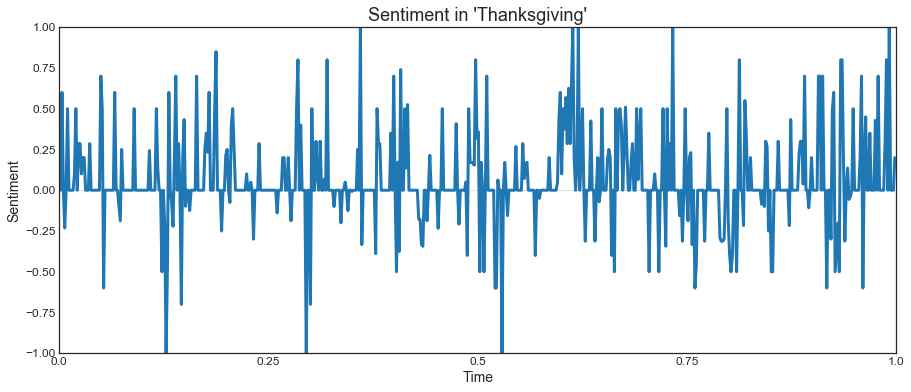

In [35]:
fig, ax = create_plot(title="Sentiment in 'Thanksgiving'", xlabel="Time",
                      ylabel="Sentiment", episode=True)

ax.plot(sentence_df['relative_position'], sentence_df['polarity'], lw=3)

plt.show()

There's a *lot* of detail here, since I've plotted the sentiments of every single sentence in the episode (and there are 602 sentences) - so it's hard to see the overall trends over the episode.

Instead of plotting the sentiment over every single sentence, I'm gonna look at the average sentiments over 'windows' of N sentences. I'll start with a default window of 3 sentences, but we can play around with that later.

In [19]:
def average_over_window(df, size=3):
    """
    Average polarities of a dataframe over a 'window' of n sentences. 
    Return dataframe columns ['polarity', 'relative_position'].
    Params:
        df: dataframe with 'polarity' column
        size: size of window
    """
    index = 0
    polarities = []
    
    while(index + size < len(df)):
        window = df[index:index+size]
        polarity = window['polarity'].mean()
        polarities.append(polarity)
        index += size
        
    averaged_polarities = pd.DataFrame({'polarity': polarities})
    averaged_polarities['relative_position'] = averaged_polarities.index / len(averaged_polarities)
    
    return averaged_polarities

In [20]:
averaged_polarities = average_over_window(sentence_df)

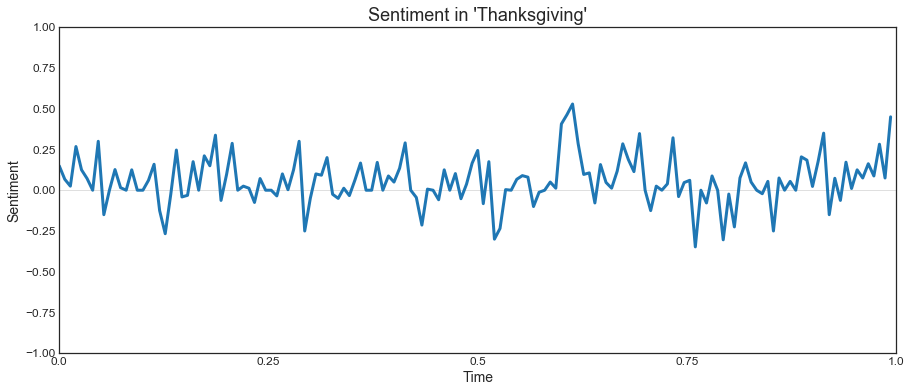

In [36]:
fig, ax = create_plot(title="Sentiment in 'Thanksgiving'", xlabel="Time",
                      ylabel="Sentiment", episode=True)

ax.plot(averaged_polarities['relative_position'], averaged_polarities['polarity'], lw=3)

plt.show()

That's a lot better. One thing to note is that we do lose some detail by averaging over windows, though. For instance, in the first graph where every single sentence is plotted, we can see the points where some *really* negative sentences are said (e.g. a sentence with a polarity of -1 around the 0.75 time mark). Since I'm now taking the averages over windows, we don't see such extreme values anymore.

Let's take a look at the some of the most positive & negative sentences in the episode!

### Top 10 Positive Sentences

In [22]:
sorted_sentences = sentence_df.sort_values(by=['polarity'], ascending=False)

In [23]:
print('Sentence|Polarity')
for index, row, in sorted_sentences[:10].iterrows():
    polarity = round(row['polarity'], 3)
    print('{}|{}'.format(row['sentence'], polarity))

Sentence|Polarity
I'm happy for you.|0.8
They're great.|0.8
Welcome darling.|0.8
Well you are welcome to come have  Thanksgiving with us anytime you want.|0.8
I said your yams turned out really nice this year!|0.75
Grandma Ernestine your yams turned out really nice this year!|0.75
That's good to know.|0.7
Yeah man it's really good.|0.7
It's so great to  Nice to meet you.|0.7
They good?|0.7


### Top 10 Negative Sentences

In [24]:
print('Sentence|Polarity')
for index, row, in sorted_sentences[::-1][:10].iterrows():
    polarity = round(row['polarity'], 3)
    print('{}|{}'.format(row['sentence'], polarity))

Sentence|Polarity
Horrible.|-1.0
That's horrible.|-1.0
Damn why you got to hate on the Pan?|-0.8
That character was an idiot.|-0.8
Stupid.|-0.8
seventeenfoot aluminum boat that broke apart    Man I told you this is stupid.|-0.8
Don't you ask another fucking question!|-0.75
Well you know my hearing is bad.|-0.7
Why would they be mad?|-0.625
I feel like all three of them are gonna be mad at you about that.|-0.625


*I said your yams turned out really nice this year!*

## Season 2

I've got all the scripts for both season 1 and 2, but I wanna just look at season 2 right now - so I'm gonna write a function that just grabs the scripts that are for a given season.

In [25]:
def get_season_episodes(directory, season):
    if season < 10:
        season_str = '0{}'.format(season) # single digit seasons are preceded by a 0
    else:
        season_str = str(season)
        
    episodes = []
    for file in os.listdir(directory):
        regex_str = r'^s{}.*'.format(season_str)
        mo = re.search(regex_str, file, re.IGNORECASE)
        if mo:
            episode = mo.group()
            episodes.append(episode)
    
    return episodes

In [26]:
def get_episode_title(text):
    """
    Return string with season/episode info & episode title.
    Params:
        text: string
    """
    return text.replace('-', ' ').replace('.txt', '')

Gonna write a function to create the dataframe of with sentence, polarity, & relative position from the dictionary of sentences & polarities.

In [27]:
def create_sentence_df(sentence_polarities, window=1):
    """
    Return dataframe with columns ['sentence', 'polarity', 'relative_position'].
    Params:
        sentence_polarities: dictionary with {sentence: polarity}
    """
    sentence_df = pd.DataFrame(list(sentence_polarities.items()),
                               columns=['sentence', 'polarity'])
    sentence_df['relative_position'] = sentence_df.index / len(sentence_df)

    return sentence_df

In [28]:
s2_episodes = get_season_episodes(episode_dir, 2)
s2_episodes = sorted(s2_episodes)

Gonna check out the sentiments over the course of each episode in season 2 now! While I'm at it, I'm gonna grab the overall polarity of each episode as a whole as well.

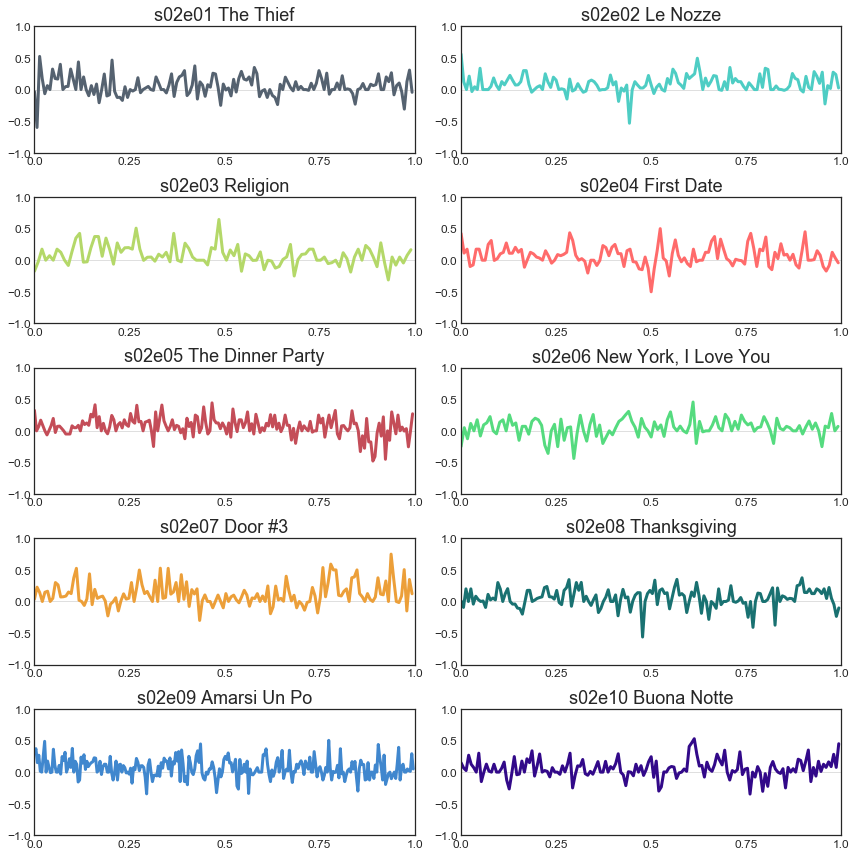

In [37]:
fig, axes = plt.subplots(figsize=(12,12), nrows=5, ncols=2)
axes = axes.reshape(-1)

episode_polarities = {}

for i, (ax, episode) in enumerate(zip(axes, s2_episodes)):
    with open('{}/{}'.format(episode_dir, episode), 'r') as f:
        text = f.read()
        cleaned_text = clean_text(text)
        blob = TextBlob(cleaned_text)
        title = get_episode_title(episode)
        
        episode_polarity = blob.sentiment.polarity
        episode_polarities[title] = episode_polarity
        
        sentence_polarities = get_sentence_polarities(blob)
        sentence_df = create_sentence_df(sentence_polarities)
        averaged_polarities = average_over_window(sentence_df, 4)
        
        fig, ax = create_plot(title=title, fig=fig, ax=ax, episode=True)

        ax.plot(averaged_polarities['relative_position'], averaged_polarities['polarity'],
                color=colors[i], lw=3)
        
plt.tight_layout() # fix overlapping text/labels     
plt.show()

The episodes, in order of most to least positive:

In [30]:
print("Episode|Polarity")
for ep in sorted(episode_polarities, key=episode_polarities.get, reverse=True):
    polarity = round(episode_polarities[ep], 5)
    print('{}|{}'.format(ep, polarity))

Episode|Polarity
s02e07 Door #3|0.25798
s02e02 Le Nozze|0.19024
s02e03 Religion|0.17524
s02e05 The Dinner Party|0.17257
s02e09 Amarsi Un Po|0.16332
s02e04 First Date|0.15358
s02e01 The Thief|0.1338
s02e10 Buona Notte|0.13298
s02e06 New York, I Love You|0.13073
s02e08 Thanksgiving|0.12602


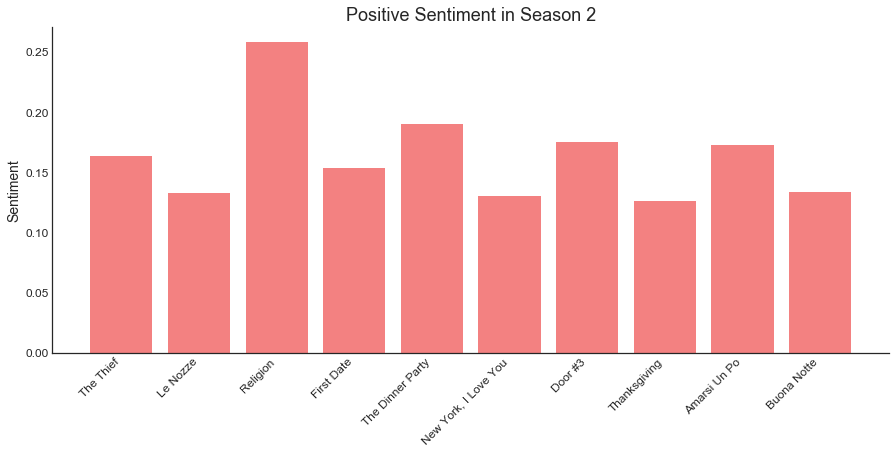

In [38]:
fig, ax = create_plot(title="Positive Sentiment in Season 2", ylabel="Sentiment")

titles = [] # extracting titles without season/episode info
for ep in list(episode_polarities.keys()):
    regex_str = r's\d+e\d+\s+(.*)'
    mo = re.search(regex_str, ep, re.IGNORECASE)
    titles.append(mo.group(1))
    
height = list(episode_polarities.values())

ax.bar(titles, height, color='#F38181')
ax.set_xticklabels(titles, rotation=45, horizontalalignment='right')
ax.spines['right'].set_visible(False) 
ax.spines['top'].set_visible(False)

plt.show()